In [1]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_nex_vor = pd.read_csv('data/TB_nex_vor.csv', parse_dates=['Date'])
df_gmdr_vor = pd.read_csv('data/TB_gmdr_vor.csv', parse_dates=['Date'])
df_wtgn_vor = pd.read_csv('data/TB_wtgn_vor.csv', parse_dates=['Date'])

In [3]:
df_nex_vor['study'] = 'NEX'
df_gmdr_vor['study'] = 'GMDR'
df_wtgn_vor['study'] = 'WTGN'

In [4]:
df_vor = pd.concat([df_nex_vor, 
                    df_gmdr_vor, 
                    df_wtgn_vor], axis=0)

In [13]:
df_vor.groupby('Year').count()

,Site,Disturbance,Exclosure,Date,Date_cln,High_cm,Low_cm,low_cm_ADJUSTED,Area_(m^2),Total_Weight_(g),Total_Weight_(g/m^2),study,Block,Paddock,Year_clip,Plot_clip,Plot,Pasture
Year,,,,,,,,,,,,,,,,,,
2015.0,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0
2018.0,36,36,36,36,36,36,36,36,36,36,36,36,0,0,0,0,0,0
2019.0,36,36,36,96,36,96,96,36,36,36,96,96,9,9,9,9,51,51
2020.0,29,29,29,84,29,84,84,29,29,29,84,84,10,10,10,10,55,45
2021.0,37,37,37,46,37,46,46,37,37,37,46,46,9,9,9,9,9,0


In [14]:
# remove spaces from column names
for c in df_vor.columns:
    if ' ' in c:
        df_vor.rename(columns={c: re.sub(' ', '_', c)}, inplace=True)

<AxesSubplot:ylabel='Frequency'>

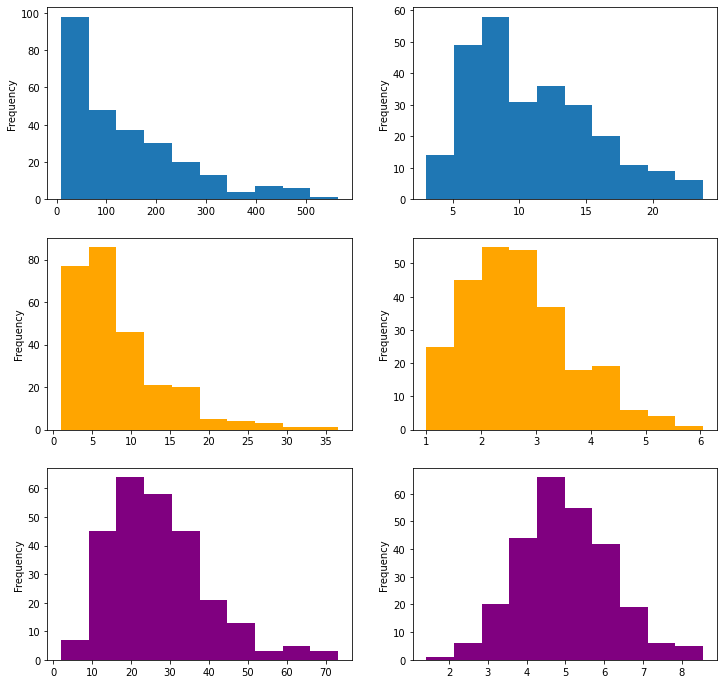

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12, 12))
df_vor['Total_Weight_(g/m^2)'].plot.hist(ax=ax[0, 0])
df_vor['Total_Weight_(g/m^2)'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[0, 1])

df_vor['Low_cm'].plot.hist(ax=ax[1, 0], color='orange')
df_vor['Low_cm'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[1, 1], color='orange')

df_vor['High_cm'].plot.hist(ax=ax[2, 0], color='purple')
df_vor['High_cm'].transform(lambda x: np.power(x, 0.5)).plot.hist(ax=ax[2, 1], color='purple')
#df_vor['Total_Weight_(g/m^2)'].transform(lambda x: np.log(x)).plot.hist(ax=ax[1])

In [63]:
mod_both = smf.ols("Q('Total_Weight_(g/m^2)') ~ Low_cm + High_cm", 
                   data=df_vor).fit()
df_vor['pred_tb'] = mod_both.predict()
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']

In [64]:
#df_nex_vor[df_nex_vor.Year == 2021]

In [65]:
from scipy.stats import shapiro
shapiro(df_vor['resid_tb'])

ShapiroResult(statistic=0.9657769799232483, pvalue=6.187119652167894e-06)

In [66]:
mod_both.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Q('Total_Weight_(g/m^2)')   R-squared:                       0.595
Model:                                   OLS   Adj. R-squared:                  0.592
Method:                        Least Squares   F-statistic:                     191.7
Date:                       Tue, 10 May 2022   Prob (F-statistic):           6.04e-52
Time:                               12:47:54   Log-Likelihood:                -1511.4
No. Observations:                        264   AIC:                             3029.
Df Residuals:                            261   BIC:                             3040.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.1354     11.217     -0.725      0.469     -30.222      13.951
Low_cm        11.6900      1.308      8.940      0.000       9.115      14.265
High_cm        1.9626      0.623      3.152      0.002       0.736       3.189
==============================================================================
Omnibus:                       31.531   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.103
Skew:                           0.595   Prob(JB):                     1.63e-15
Kurtosis:                       5.186   Cond. No.                         75.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Things to try
* Covariate of precip (try a mixed model first as test)
* Add in 2021 NEX data (and check why more 2021 is not in there)

### Next steps
* Work with Lauren to gather all biomass (clipping) data in prep for satellite model

In [67]:
np.sqrt(df_vor.apply(lambda x: np.power(x['pred_tb'] - x['Total_Weight_(g/m^2)'], 
                                2), axis=1).mean()) / df_vor['Total_Weight_(g/m^2)'].mean()

0.5305154098684163

In [68]:
df_vor.apply(lambda x: abs(x['pred_tb'] - x['Total_Weight_(g/m^2)']), axis=1).mean()

53.89850385130731

In [73]:
np.sqrt(df_vor.apply(lambda x: np.power(x['pred_cper'] - x['Total_Weight_(g/m^2)'], 
                                2), axis=1).mean()) / df_vor['Total_Weight_(g/m^2)'].mean()

0.5983296083997333

In [74]:
df_vor.apply(lambda x: abs(x['pred_cper'] - x['Total_Weight_(g/m^2)']), axis=1).mean()

63.357713607085635

eval_env: 1
eval_env: 1
eval_env: 1


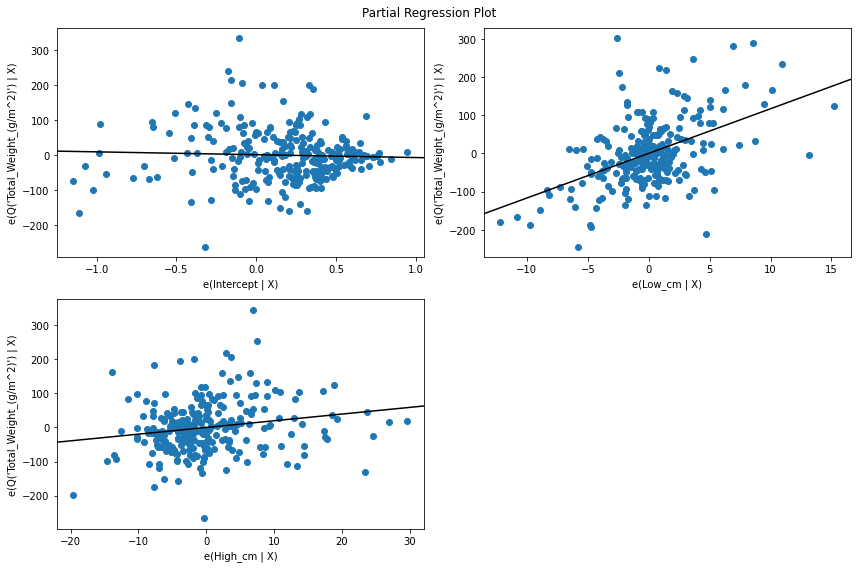

In [69]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_partregress_grid(mod_both, fig=fig)
fig.tight_layout(pad=1.0)

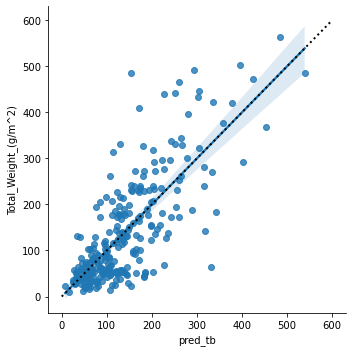

In [70]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(x='pred_tb',
           y='Total_Weight_(g/m^2)',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

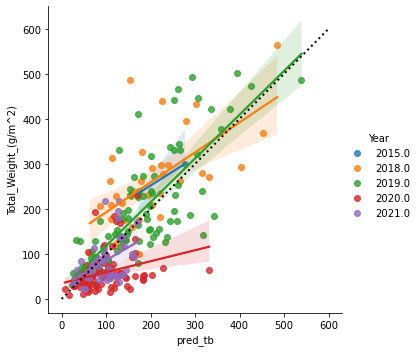

In [71]:
df_vor['resid_tb'] = df_vor['pred_tb'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(x='pred_tb',
           y='Total_Weight_(g/m^2)',
           hue='Year',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

### other data
* there is VOR+clipping data from weight gain project, not ready yet (2019 might be ready, not sure about VOR, Elle is weighing 2020 data) - will prioritize 2019/2020 VOR
    * this will be the best VOR/Clipping data
    * 2019 - much of the VOR data won't be usable (but clipping is ok!). Lauren needs to figure out when date cut-off is for fix.
* Courtenay's bird habitat project has a ton of VOR data (30 m transects, since 2015) - can talk with David about this.
    * Clipping done a month later about 8 m away at subset of locations(60-80 locs)
* some other projects from 2014/2015 that Lauren can access
    * This would be nice to expand spatial coverage and burns
* USFS project in 2015/2016 - grid sampliing
    * not sure of their protocol (observations may be too limited)
    * data might be hard to access (a lot of people no longer there)

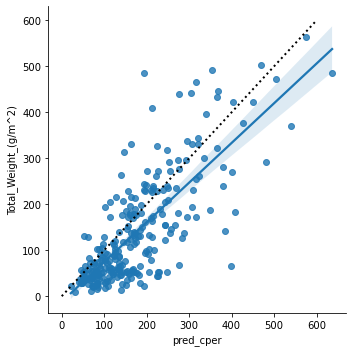

In [34]:
df_vor['pred_cper'] = (32.9 + 133.6*df_vor['Low_cm'] + 23.7*df_vor['High_cm'])/10
df_vor['resid_cper'] = df_vor['pred_cper'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(x='pred_cper',
           y='Total_Weight_(g/m^2)',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

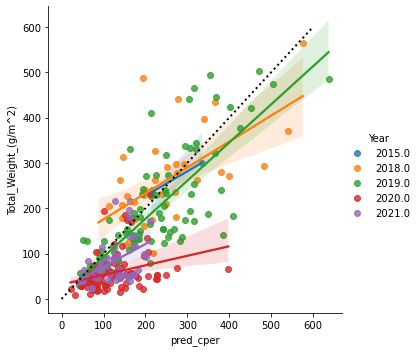

In [35]:
df_vor['pred_cper'] = (32.9 + 133.6*df_vor['Low_cm'] + 23.7*df_vor['High_cm'])/10
df_vor['resid_cper'] = df_vor['pred_cper'] - df_vor['Total_Weight_(g/m^2)']
sns.lmplot(x='pred_cper',
           y='Total_Weight_(g/m^2)',
           hue='Year',
           data=df_vor)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

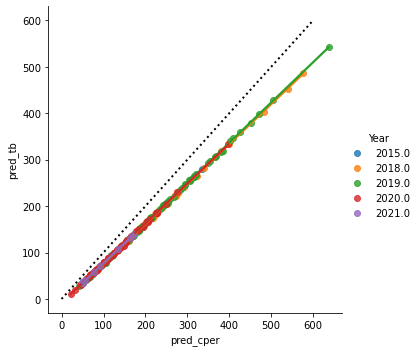

In [53]:
sns.lmplot(x='pred_cper',
           y='pred_tb',
           data=df_vor,
           hue='Year')
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

In [43]:
(df_vor['pred_cper'] - df_vor['pred_tb']).max()

94.24399312534467